In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("data/Drugbank2019_MS_CFMID4.0.json", mode = "r") as drugbank:
    db = json.load(drugbank)

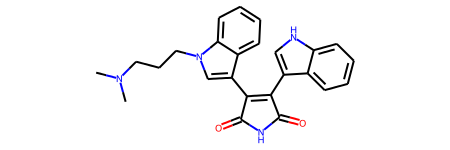

In [13]:
from rdkit import Chem
Chem.MolFromSmiles("CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15")

In [14]:
Chem.CanonSmiles("CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15")

'CN(C)CCCn1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=O)c2ccccc21'

In [2]:
from functools import partial
# input: 3 mass spectra at different energy levels
# output: 3 gaussian mixture kernels which interpolate the spectra

def create_gaussian_mixtures(energy_tuple, sigma = 1):
    def _mixture(ms):
        mz     = ms["mz"]
        intens = ms["intens"]
        #print()
        #print(mz)
        #print(intens)
        gauss  = list()
        for (peak, intens) in zip(mz, intens):
            # When a lambda is created, it doesn't make a copy of the variables in the enclosing scope that it uses
            lambda_gaussian = lambda x, peak, intens, sigma : intens * np.exp(-.5*np.power((x - peak)/sigma,2))
            gauss.append(
                partial(
                    lambda_gaussian,
                    peak   = peak,
                    intens = intens,
                    sigma  = sigma
                )
            )
            
        return lambda x : (mix := sum([ f(x) for f in gauss ]))/np.max(mix)
    
    mixtures = list()
    for e in energy_tuple:
        mixtures.append(_mixture(e))

    return tuple(mixtures)

for m in db:
    mixs = create_gaussian_mixtures((db[m]["energy0"],db[m]["energy1"],db[m]["energy2"]))
    break

<IPython.core.display.Javascript object>


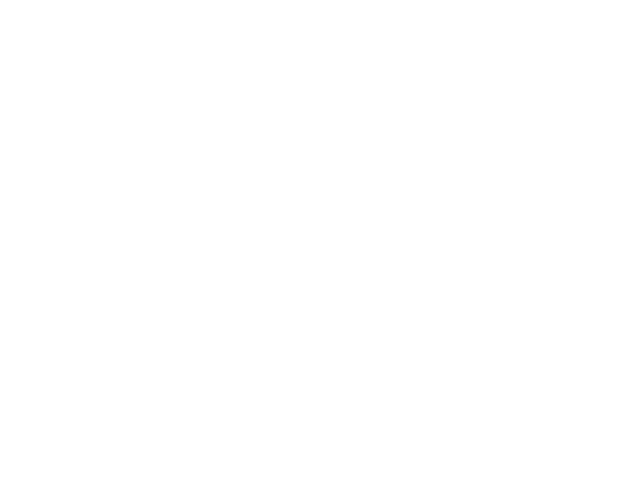

In [3]:
%matplotlib notebook
x_def = np.arange(0, 400, 0.005)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x_def, mixs[1](x_def))


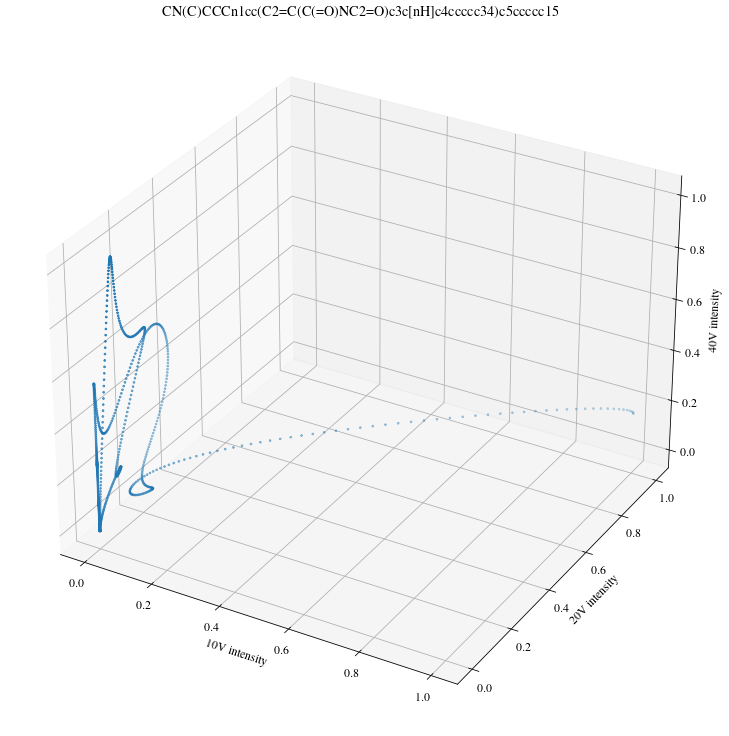

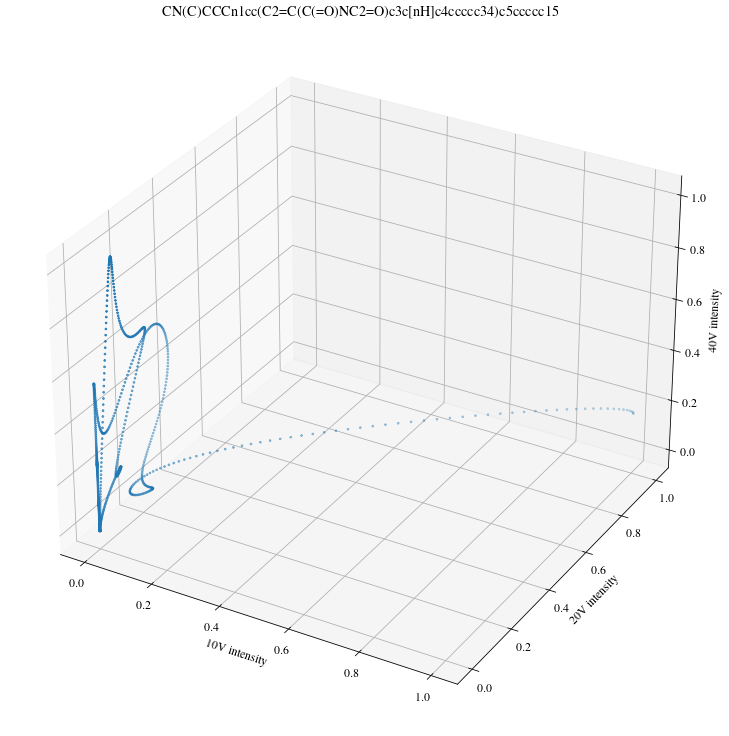

In [4]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size": 12,
})

import time
from IPython import display
for m in db:
    if m != "CN(C)CCCn1cc(C2=C(C(=O)NC2=O)c3c[nH]c4ccccc34)c5ccccc15":
        continue
        
    mixs = create_gaussian_mixtures(
        (db[m]["energy0"],db[m]["energy1"],db[m]["energy2"]),
        sigma = 10
    )
    Max_mass = max([ max(e["mz"]) for e in (db[m]["energy0"],db[m]["energy1"],db[m]["energy2"]) ])
    x_def = np.linspace(
        0,
        Max_mass,
        num=1000,
    )
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(1,1,1, projection="3d")
    ax.scatter(mixs[0](x_def), mixs[1](x_def), mixs[2](x_def), s= 3, marker= "x")
    ax.set_title(m)
    ax.set_xlabel("10V intensity")
    ax.set_ylabel("20V intensity")
    ax.set_zlabel("40V intensity")
    #------------------------------------------
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

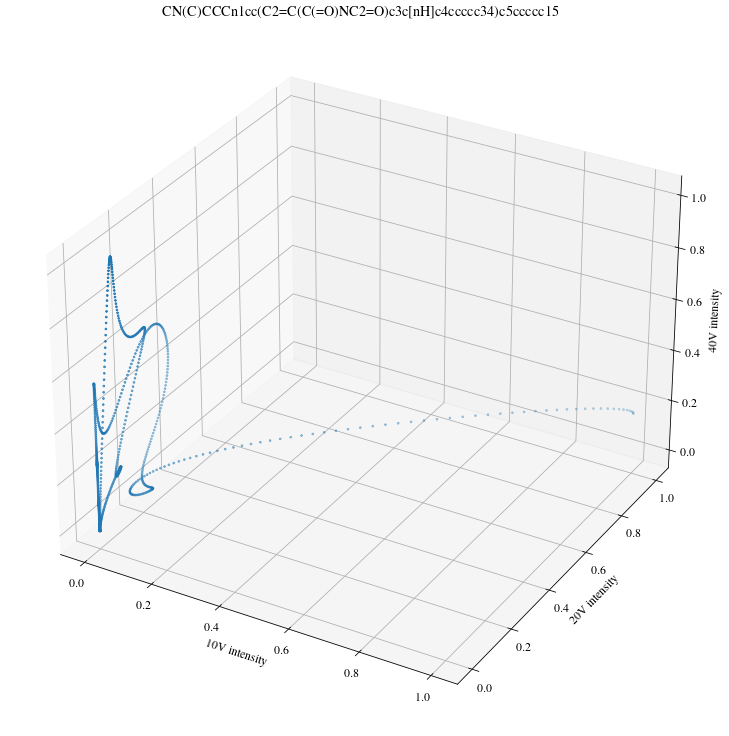

In [5]:
%matplotlib notebook
fig